In [17]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

plt.style.use("science")

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

### Data-driven machine learning model to predict the effective coupled properties of magneto-electro-elastic auxetic structures

Mohamed Amine Bakkoury - Supervised by Prof. Vinyas Mahesh & Prof. Sathiskumar A Ponnusami   

This notebook aims at complementing the project's final report by providing details of the approach followed for this work (from data collection to modeling), along with insights from the analysis and modeling of the data

## Data loading and preparation

The first step of our analysis is to load outputs gathered from COMSOL simulations and organized into a csv table

In [18]:
# loading the output results from COMSOL simulations
df = pd.read_csv("comsol_simulations.csv").rename(
    columns={"Frequency #": "frequency_order"}
)

In [19]:
# process columns for easier manipulation
df.columns = [
    x.lower().strip().replace(" ", "_").replace("'s", "").replace("_(hz)", "")
    for x in df.columns
]

In [20]:
print(df.shape)
df.head()

(2520, 13)


,unit_cell_height,base_length,side_length,structure_height,structure_length,material,young_modulus,density,poisson_ratio,boundary_conditions,frequency_order,hexagonal_eigenfrequency,auxetic_eigenfrequency
0,13.0,16.0,8.5,72.0,162.8,Steel,"2,05E+11",7850,0.28,FNF,1,2092.3,1691.1
1,13.0,16.0,8.5,72.0,162.8,Steel,"2,05E+11",7850,0.28,FNF,2,2833.1,3736.0
2,13.0,16.0,8.5,72.0,162.8,Steel,"2,05E+11",7850,0.28,FNF,3,2850.0,3858.7
3,13.0,16.0,8.5,72.0,162.8,Steel,"2,05E+11",7850,0.28,FNF,4,3667.2,4067.8
4,13.0,16.0,8.5,72.0,162.8,Steel,"2,05E+11",7850,0.28,FNF,5,3783.0,4447.3


Each row of the dataset provides the natural frequency (order 1-10) for a specific geometry for a specific material. Our dataset contains 13 columns:
- Material related columns: these are specific to the material described in the row: `material`, `young_modulus`, `density`, `poisson_ratio`. These are unchanged when different geometries are considered and describe the physical properties of the studied material
- Geometry related columns: `unit_cell_height`, `base_length`, `side_length`, `structure_length`. These columns describe the geometry described in the row
- Simulation related columns: `boundary_conditions`. These columns specify the conditions chosen for the simulation
- Finally, `hexagonal_eigenfrequency` and `auxetic_eigenfrequency` contain the eigenfrequency (of order `frequency_order`) of the material in, respectively, its hexagonal and auxetic shapes

## Data exploration

The dataset has been manually collected from several COMSOL simulations performed. The objective has been to add various materials and different geometries for each of these materials, to provide data as diverse as possible. Please note that the dataset size has been limited by ...

Text(0, 0.5, 'Poisson ratio')

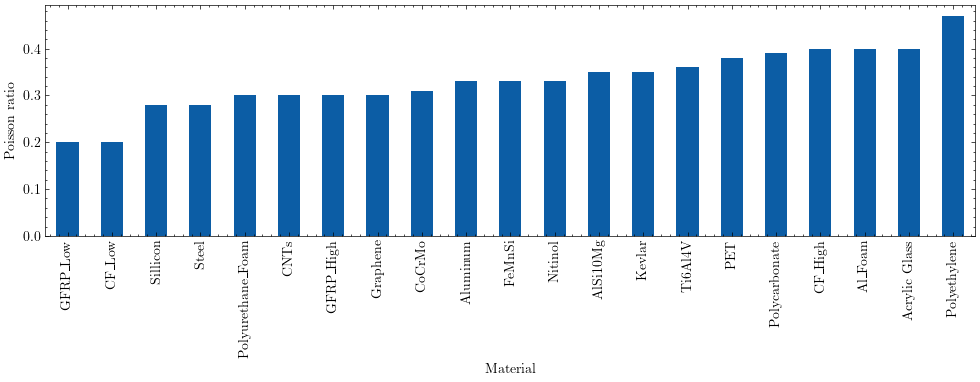

In [21]:
# visualize the different materials in the dataset and their poisson ratio
plt.figure(figsize=(12, 3))
df.groupby("material")["poisson_ratio"].first().sort_values().plot.bar()
plt.xlabel("Material")
plt.ylabel("Poisson ratio")

In [22]:
# process young modulus (transform from string to float)
df["young_modulus"] = df["young_modulus"].str.replace(",", ".").astype(float)

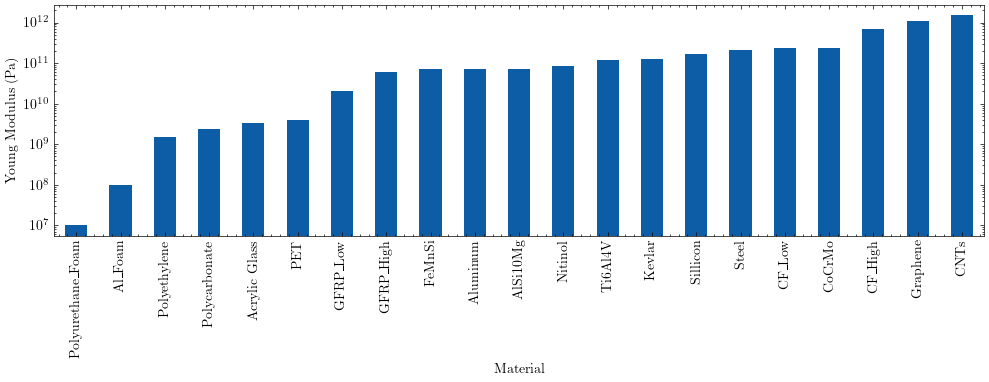

In [23]:
# visualize the different materials in the dataset and their young modulus
plt.figure(figsize=(12, 3))
df.groupby("material")["young_modulus"].first().sort_values().plot.bar()
plt.xlabel("Material")
plt.ylabel("Young Modulus (Pa)")
plt.yscale("log")

Text(0, 0.5, 'Density (kg/m³)')

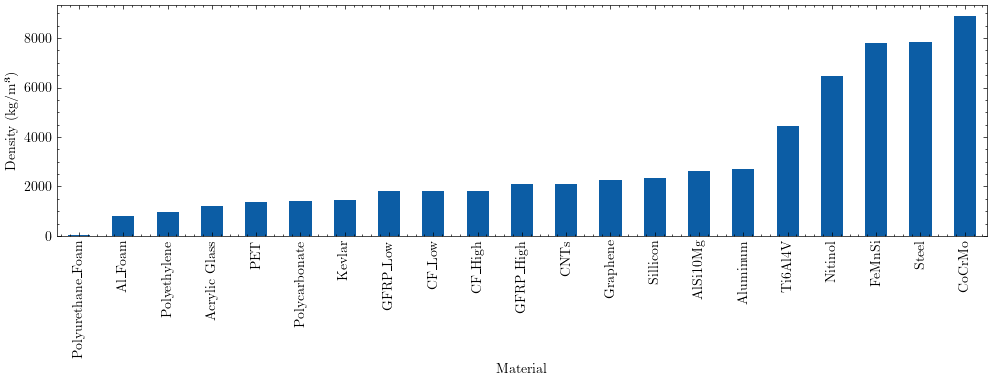

In [24]:
# visualize the different materials in the dataset and their young modulus
plt.figure(figsize=(12, 3))
df.groupby("material")["density"].first().sort_values().plot.bar()
plt.xlabel("Material")
plt.ylabel("Density (kg/m³)")

Text(0.5, 0.98, 'Histograms of eigenfrequencies for hexagonal and auxetic structures')

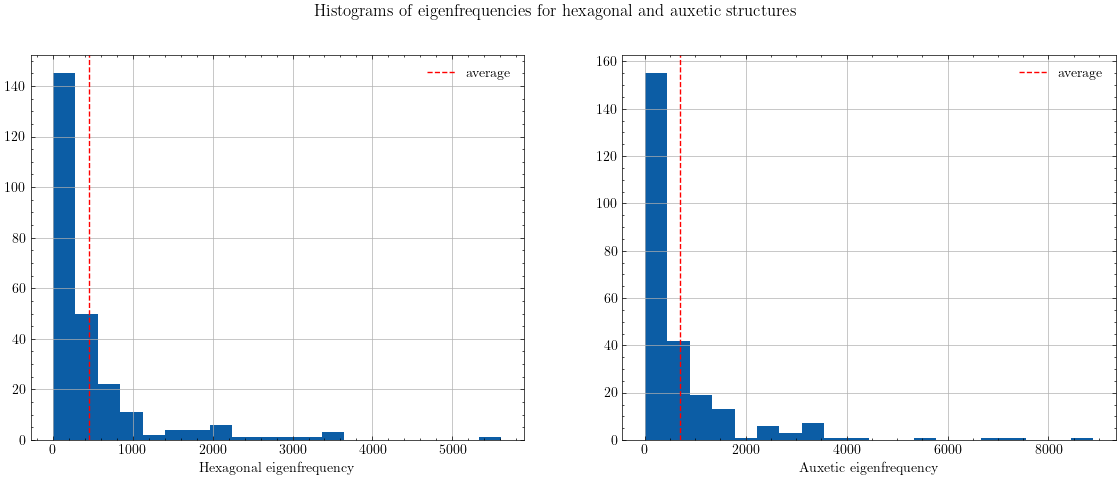

In [25]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
df.query("frequency_order == 1")["hexagonal_eigenfrequency"].hist(ax=ax1, bins=20)
ax1.axvline(
    df.query("frequency_order == 1")["hexagonal_eigenfrequency"].mean(),
    color="red",
    linestyle="--",
    label="average",
)
df.query("frequency_order == 1")["auxetic_eigenfrequency"].hist(ax=ax2, bins=20)
ax2.axvline(
    df.query("frequency_order == 1")["auxetic_eigenfrequency"].mean(),
    color="red",
    linestyle="--",
    label="average",
)
ax1.set_xlabel("Hexagonal eigenfrequency")
ax2.set_xlabel("Auxetic eigenfrequency")
ax1.legend(), ax2.legend()
fig.suptitle("Histograms of eigenfrequencies for hexagonal and auxetic structures")

From the above charts, it seems like we observe more often higher first order eigenfrequencies for auxetic materials

Text(0.5, 0, 'Boundary conditions')

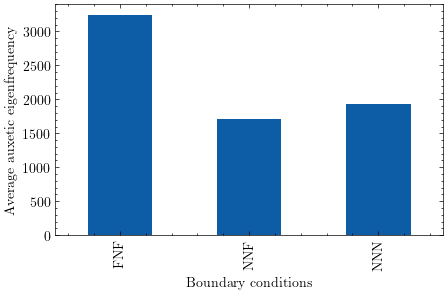

In [26]:
plt.figure(figsize=(5, 3))
df.groupby("boundary_conditions")["auxetic_eigenfrequency"].mean().plot.bar()
plt.ylabel("Average auxetic eigenfrequency")
plt.xlabel("Boundary conditions")

### Relation between hexagonal and auxetic eigenfrequencies

Intuitively, we can expect hexagonal and auxetic eigenfrequencies to be highly correlated. Indeed, these are natural frequencies of the same material under different shapes. This intuition can be verified by running an analysis of the relation between `hexagonal_eigenfrequency` and `auxetic_eigenfrequency` variables.

#### Overall relationship

In [27]:
# build unidimensional linear regression
model_1d = smf.ols("auxetic_eigenfrequency ~ hexagonal_eigenfrequency", data=df).fit()

In [28]:
model_1d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     auxetic_eigenfrequency   R-squared:                       0.836
Model:                                OLS   Adj. R-squared:                  0.836
Method:                     Least Squares   F-statistic:                 1.282e+04
Date:                    Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                            16:43:10   Log-Likelihood:                -21887.
No. Observations:                    2520   AIC:                         4.378e+04
Df Residuals:                        2518   BIC:                         4.379e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -44.8679     35.216     -1.274      0.203    -113.923      24.187
hexagonal_eigenfrequency     1.3946      0.012    113.233      0.000       1.370       1.419
==============================================================================
Omnibus:                     1359.705   Durbin-Watson:                   0.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50919.846
Skew:                           1.906   Prob(JB):                         0.00
Kurtosis:                      24.689   Cond. No.                     3.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Auxetic eigenfrequency')

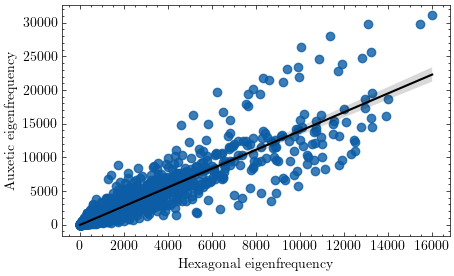

In [29]:
# fitted regression visualization

plt.figure(figsize=(5, 3))
sns.regplot(
    x="hexagonal_eigenfrequency",
    y="auxetic_eigenfrequency",
    data=df,
    line_kws={"color": "black"},
)
plt.xlabel("Hexagonal eigenfrequency")
plt.ylabel("Auxetic eigenfrequency")

As expected, there is a high correlation between eigenfrequencies of the material in the two structures. Indeed, by having an overview, it seems like `hexagonal_eigenfrequency` explains 83% of the variability in the auxetic frequencies. In a second step, we propose to evaluate the individual relationships of different orders frequencies, to understand if we find a similar result at all orders

#### Frequencies order breakdown


In [30]:
# define R^2 metric as the pearson correlation coefficient for 1D regression
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

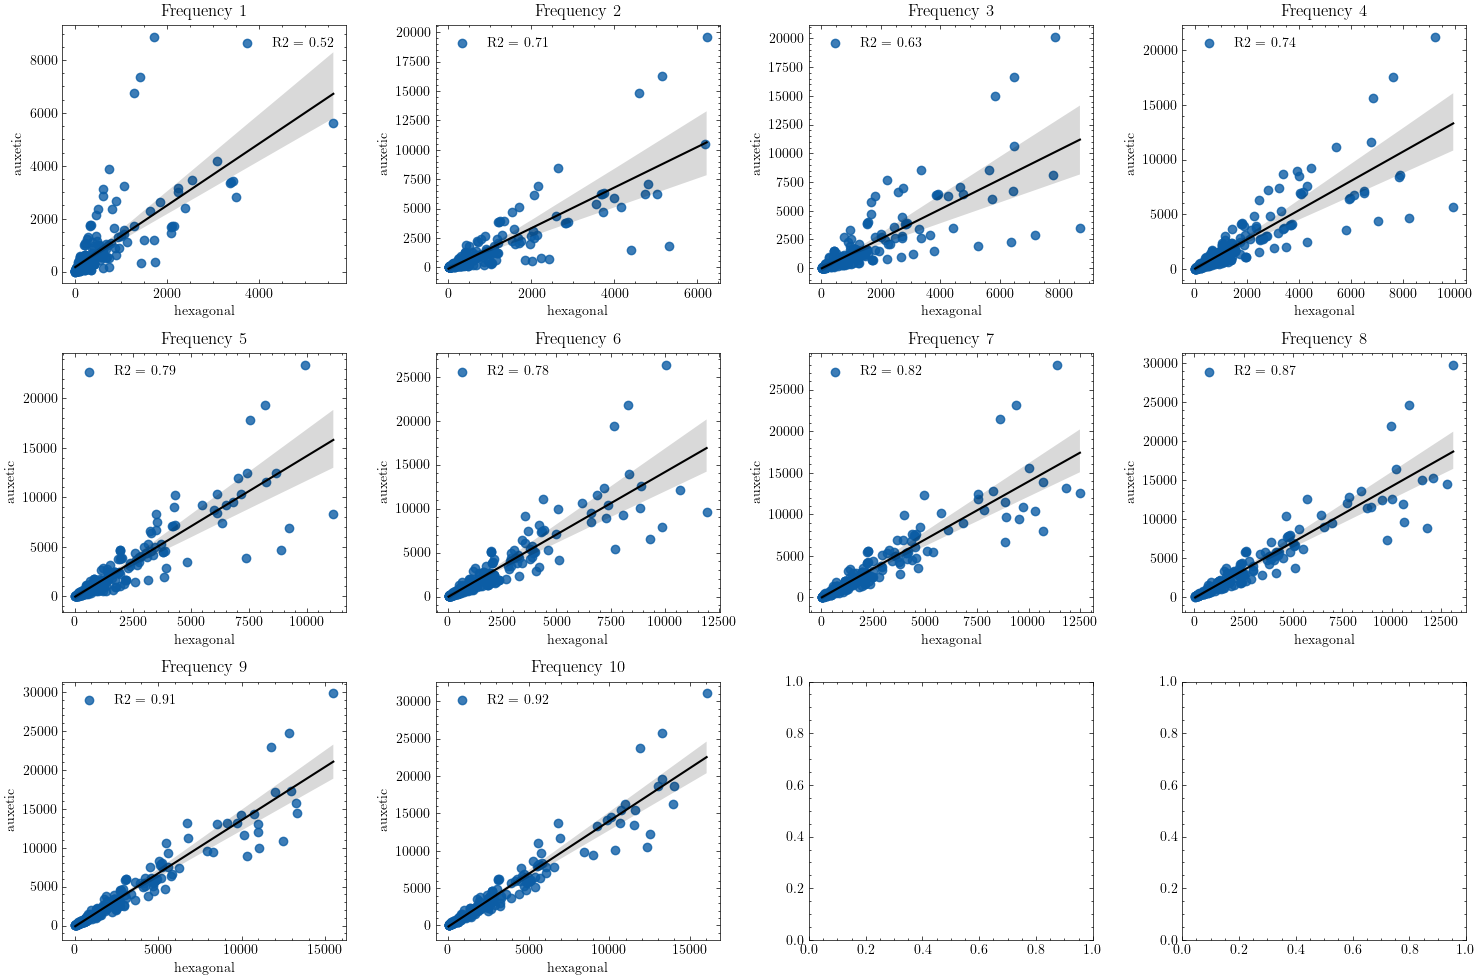

In [31]:
fig, _ = plt.subplots(3, 4, figsize=(15, 10))
for frequency_order in range(1, 11):
    particular_df = df.query("frequency_order == @frequency_order")
    ax = plt.subplot(3, 4, frequency_order)
    # plot the regression chart for each frequency order
    sns.regplot(
        x="hexagonal_eigenfrequency",
        y="auxetic_eigenfrequency",
        data=particular_df,
        line_kws={"color": "black"},
        ax=ax,
        label=f"R2 = {round(r2(particular_df['hexagonal_eigenfrequency'], particular_df['auxetic_eigenfrequency']), 2)}",
    )
    ax.set_title(f"Frequency {frequency_order}")
    ax.set_xlabel("hexagonal")
    ax.set_ylabel("auxetic")
    ax.legend()
fig.tight_layout()

This analysis shows a clear imbalance between low and high order natural frequencies. For example, while frequencies #10 are highly correlated (with an R^2 of 0.92), it looks like smaller orders frequencies have weaker relationships. This can be explained by outliers wee see when plotting the data points (especially high auxetic natural frequencies). This result is aligned with the histograms we have plotted above. We will have to take this into account in our modeling

## Modeling

### Dataset split

An important part of this process is to split our data into two sets: 
- A training set
- A test set

This procedure ensures we best evaluate robustness of our model to new materials or structures. We want to make sure we evaluate the model on data it has never been exposed to during the training process

In [32]:
df["material"].unique()

array(['Steel', 'AlSi10Mg', 'Al_Foam', 'CF_High', 'CF_Low', 'CNTs',
       'FeMnSi', 'GFRP_High', 'GFRP_Low', 'Graphene', 'Kevlar', 'PET',
       'Polycarbonate', 'Polyurethane_Foam', 'Ti6Al4V', 'Aluminum',
       'Sillicon', 'Nitinol', 'Polyethylene', 'Acrylic Glass', 'CoCrMo'],
      dtype=object)

In [33]:
TRAIN_MATERIALS = [
    "Steel",
    "AlSi10Mg",
    "Al_Foam",
    "CF_High",
    "CF_Low",
    "CNTs",
    "FeMnSi",
    "GFRP_High",
    "GFRP_Low",
    "Kevlar",
    "PET",
    "Polycarbonate",
    "Polyurethane_Foam",
    "Ti6Al4V",
    "Aluminum",
    "Nitinol",
    "Polyethylene",
    "Acrylic Glass",
]

TEST_MATERIALS = ["Sillicon", "CoCrMo", "Graphene"]

TARGET_VARIABLE = "auxetic_eigenfrequency"

In [34]:
df_train = df.query("material in @TRAIN_MATERIALS")
df_test = df.query("material in @TEST_MATERIALS")

### Feature engineering

In [35]:
COLUMNS_TO_DROP = ["material"]
df_train = df_train.drop(COLUMNS_TO_DROP, axis=1).reset_index(drop=True)
df_test = df_test.drop(COLUMNS_TO_DROP, axis=1).reset_index(drop=True)

In [36]:
MODELING_COLUMNS = [
    "hexagonal_eigenfrequency",
    "young_modulus",
    "poisson_ratio",
    "density",
    "unit_cell_height",
    "base_length",
    "side_length",
    "structure_height",
    "boundary_conditions",
]

In [37]:
X_train, y_train = df_train[MODELING_COLUMNS], df_train[TARGET_VARIABLE]
X_test, y_test = df_test[MODELING_COLUMNS], df_test[TARGET_VARIABLE]

In [38]:
# encode categorical features

CAT_FEATURES = X_train.select_dtypes(include=object).columns

In [39]:
X_train

,hexagonal_eigenfrequency,young_modulus,poisson_ratio,density,unit_cell_height,base_length,side_length,structure_height,boundary_conditions
0,2092.300000,2.050000e+11,0.28,7850,13.00,16.0,8.5,72.0,FNF
1,2833.100000,2.050000e+11,0.28,7850,13.00,16.0,8.5,72.0,FNF
2,2850.000000,2.050000e+11,0.28,7850,13.00,16.0,8.5,72.0,FNF
3,3667.200000,2.050000e+11,0.28,7850,13.00,16.0,8.5,72.0,FNF
4,3783.000000,2.050000e+11,0.28,7850,13.00,16.0,8.5,72.0,FNF
...,...,...,...,...,...,...,...,...,...
2155,421.435870,1.200000e+11,0.36,4430,34.64,30.0,20.0,178.2,NNN
2156,479.759492,1.200000e+11,0.36,4430,34.64,30.0,20.0,178.2,NNN
2157,582.629451,1.200000e+11,0.36,4430,34.64,30.0,20.0,178.2,NNN
2158,595.170616,1.200000e+11,0.36,4430,34.64,30.0,20.0,178.2,NNN


In [40]:
for categorical_feature in CAT_FEATURES:
    encoder = OneHotEncoder(drop="first")
    encodings = pd.DataFrame(
        encoder.fit_transform(X_train[[categorical_feature]]).toarray(),
        columns=encoder.get_feature_names_out(),
    )
    X_train = pd.concat([X_train.drop(categorical_feature, axis=1), encodings], axis=1)
    test_encodings = pd.DataFrame(
        encoder.transform(X_test[[categorical_feature]]).toarray(),
        columns=encoder.get_feature_names_out(),
    )
    X_test = pd.concat(
        [X_test.drop(categorical_feature, axis=1), test_encodings], axis=1
    )

In [41]:
NUMERICAL_FEATURES = X_train.select_dtypes(exclude=object).columns

In [42]:
# normalize dataset features
standard_scaler = MinMaxScaler()
X_train[NUMERICAL_FEATURES] = standard_scaler.fit_transform(X_train[NUMERICAL_FEATURES])
X_test[NUMERICAL_FEATURES] = standard_scaler.transform(X_test[NUMERICAL_FEATURES])

### Model selection and training

Now that we have prepared the dataset to be ingested by an ML model, we can start the modeling task and select our model

In [43]:
CANDIDATE_MODELS = [
    LinearRegression,
    Lasso,
    DecisionTreeRegressor,
    RandomForestRegressor,
    XGBRegressor,
]

In [65]:
for candidate_model in CANDIDATE_MODELS:
    model = candidate_model().fit(X_train, y_train)
    print(
        f"{model.__class__.__name__} -  R2: {round(model.score(X_test, y_test), 2)} - MAE: {round(mean_absolute_error(y_test, model.predict(X_test)))} - RMSE: {round(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))}"
    )

LinearRegression -  R2: 0.82 - MAE: 1152 - RMSE: 1897
Lasso -  R2: 0.82 - MAE: 1148 - RMSE: 1897
DecisionTreeRegressor -  R2: 0.75 - MAE: 1067 - RMSE: 2251
RandomForestRegressor -  R2: 0.86 - MAE: 866 - RMSE: 1653
XGBRegressor -  R2: 0.89 - MAE: 831 - RMSE: 1503


In [45]:
# select model
# model = LinearRegression()
# model = Lasso()
# model = DecisionTreeRegressor()
# model = RandomForestRegressor()
model = XGBRegressor()

In [46]:
# fit model on training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
predictions = model.predict(X_test)

In [48]:
print("R2:", r2_score(y_test, predictions))
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, predictions))} Hz")
print(
    f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y_test, predictions)))} Hz"
)

R2: 0.8876450933469582
Mean Absolute Error: 831 Hz
Root Mean Squared Error: 1503 Hz


In [49]:
results = pd.concat(
    [X_test, y_test, pd.Series(predictions).rename("predicted_auxetic_eigenfrequency")],
    axis=1,
)
results.head()

,hexagonal_eigenfrequency,young_modulus,poisson_ratio,density,unit_cell_height,base_length,side_length,structure_height,boundary_conditions_NNF,boundary_conditions_NNN,auxetic_eigenfrequency,predicted_auxetic_eigenfrequency
0,0.088559,0.733332,0.37037,0.282051,0.219336,0.0,0.120795,0.233766,0.0,0.0,7351.295947,8153.077637
1,0.321211,0.733332,0.37037,0.282051,0.219336,0.0,0.120795,0.233766,0.0,0.0,16241.687132,12960.817383
2,0.405538,0.733332,0.37037,0.282051,0.219336,0.0,0.120795,0.233766,0.0,0.0,16667.640160,16854.183594
3,0.476500,0.733332,0.37037,0.282051,0.219336,0.0,0.120795,0.233766,0.0,0.0,17573.492503,20128.927734
4,0.511922,0.733332,0.37037,0.282051,0.219336,0.0,0.120795,0.233766,0.0,0.0,19338.700737,22154.949219


Text(0, 0.5, 'Predicted auxetic eigenfrequency')

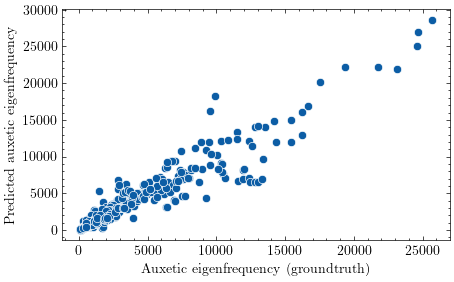

In [50]:
plt.figure(figsize=(5, 3))
sns.scatterplot(
    x="auxetic_eigenfrequency", y="predicted_auxetic_eigenfrequency", data=results
)
plt.xlabel("Auxetic eigenfrequency (groundtruth)")
plt.ylabel("Predicted auxetic eigenfrequency")

### Error analysis

-6.430996093750024

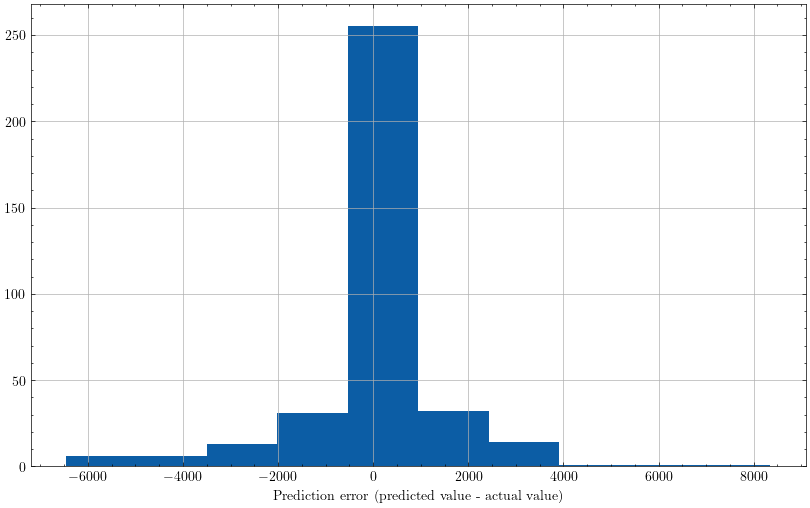

In [70]:
plt.figure(figsize=(10, 6))
(predictions - y_test).hist()
plt.xlabel("Prediction error (predicted value - actual value)")

(predictions - y_test).quantile(0.45)

In [52]:
test_data = df.query("material in @TEST_MATERIALS")
test_data["predicted_auxetic_eigenfrequency"] = predictions
test_data["prediction_error"] = (
    test_data["predicted_auxetic_eigenfrequency"] - test_data["auxetic_eigenfrequency"]
)

/var/folders/8_/1krl5fld2b30z7mw466qlh4r0000gn/T/ipykernel_73047/3962730348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["predicted_auxetic_eigenfrequency"] = predictions
/var/folders/8_/1krl5fld2b30z7mw466qlh4r0000gn/T/ipykernel_73047/3962730348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["prediction_error"] = (


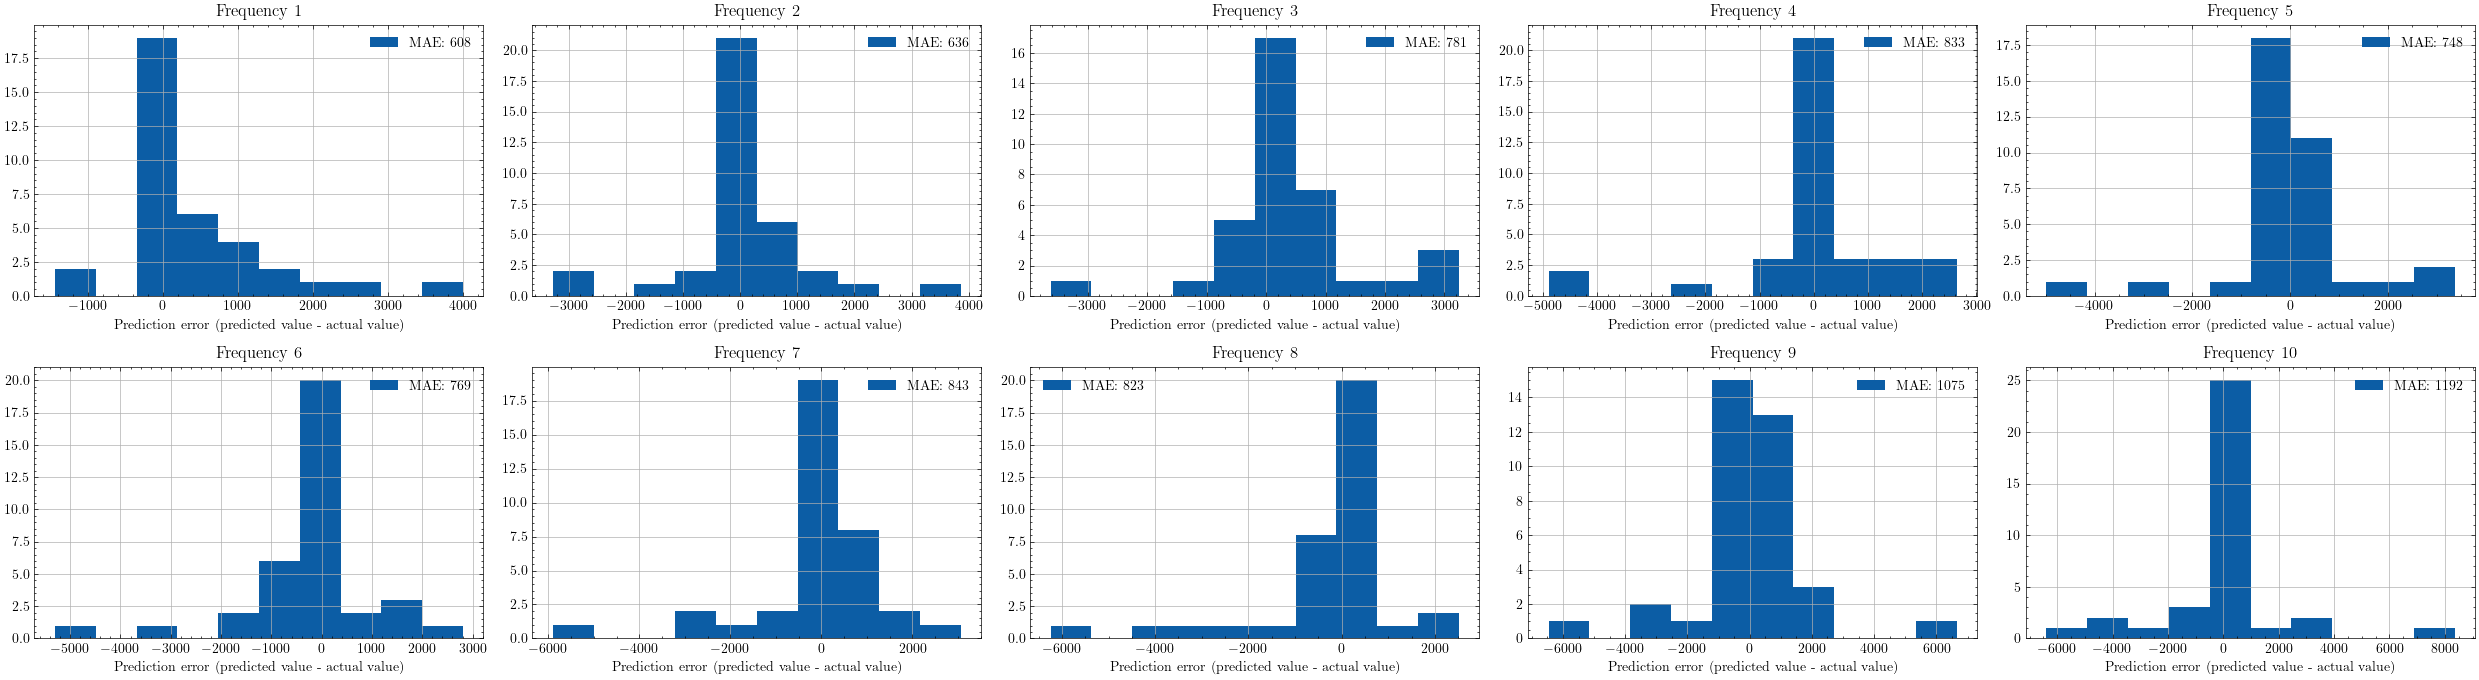

In [53]:
fig, _ = plt.subplots(2, 5, figsize=(25, 7))
for frequency_order in range(1, 11):
    particular_df = test_data.query("frequency_order == @frequency_order")
    ax = plt.subplot(2, 5, frequency_order)
    particular_df["prediction_error"].hist(
        ax=ax, label=f"MAE: {round(particular_df['prediction_error'].abs().mean())}"
    )
    ax.set_title(f"Frequency {frequency_order}")
    ax.set_xlabel("Prediction error (predicted value - actual value)")
    ax.legend()
fig.tight_layout()

Text(0, 0.5, 'Normalized mean absolute error')

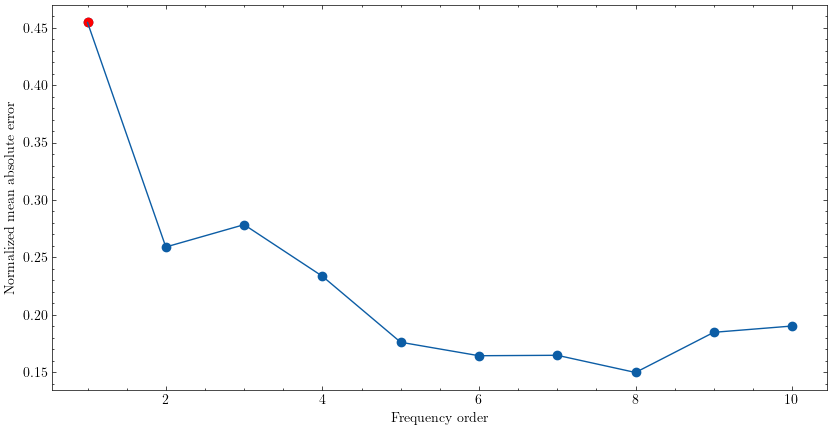

In [54]:
plt.figure(figsize=(10, 5))
plt.scatter(
    range(1, 11),
    [
        test_data.query("frequency_order == @frequency_order")["prediction_error"]
        .abs()
        .mean()
        / test_data.query("frequency_order == @frequency_order")[
            "auxetic_eigenfrequency"
        ].mean()
        for frequency_order in range(1, 11)
    ],
)
plt.scatter(
    [1],
    [
        test_data.query("frequency_order == 1")["prediction_error"].abs().mean()
        / test_data.query("frequency_order == 1")["auxetic_eigenfrequency"].mean()
    ],
    color="red",
)
plt.plot(
    range(1, 11),
    [
        test_data.query("frequency_order == @frequency_order")["prediction_error"]
        .abs()
        .mean()
        / test_data.query("frequency_order == @frequency_order")[
            "auxetic_eigenfrequency"
        ].mean()
        for frequency_order in range(1, 11)
    ],
)

plt.xlabel("Frequency order")
plt.ylabel("Normalized mean absolute error")

We observe large errors on order 1 frequencies especially compared to the frequency values (red point in the chart above). A potential solution to this issue may be to train specific models for each eigenfrequency order, this will be made possible with more training data 

### Model interpretation

In [55]:
# coefficients = model.coef_  # linear regression
coefficients = model.feature_importances_  # tree model

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'hexagonal_eigenfrequency'),
  Text(1, 0, 'young_modulus'),
  Text(2, 0, 'poisson_ratio'),
  Text(3, 0, 'density'),
  Text(4, 0, 'unit_cell_height'),
  Text(5, 0, 'base_length'),
  Text(6, 0, 'side_length'),
  Text(7, 0, 'structure_height'),
  Text(8, 0, 'boundary_conditions_NNF'),
  Text(9, 0, 'boundary_conditions_NNN')])

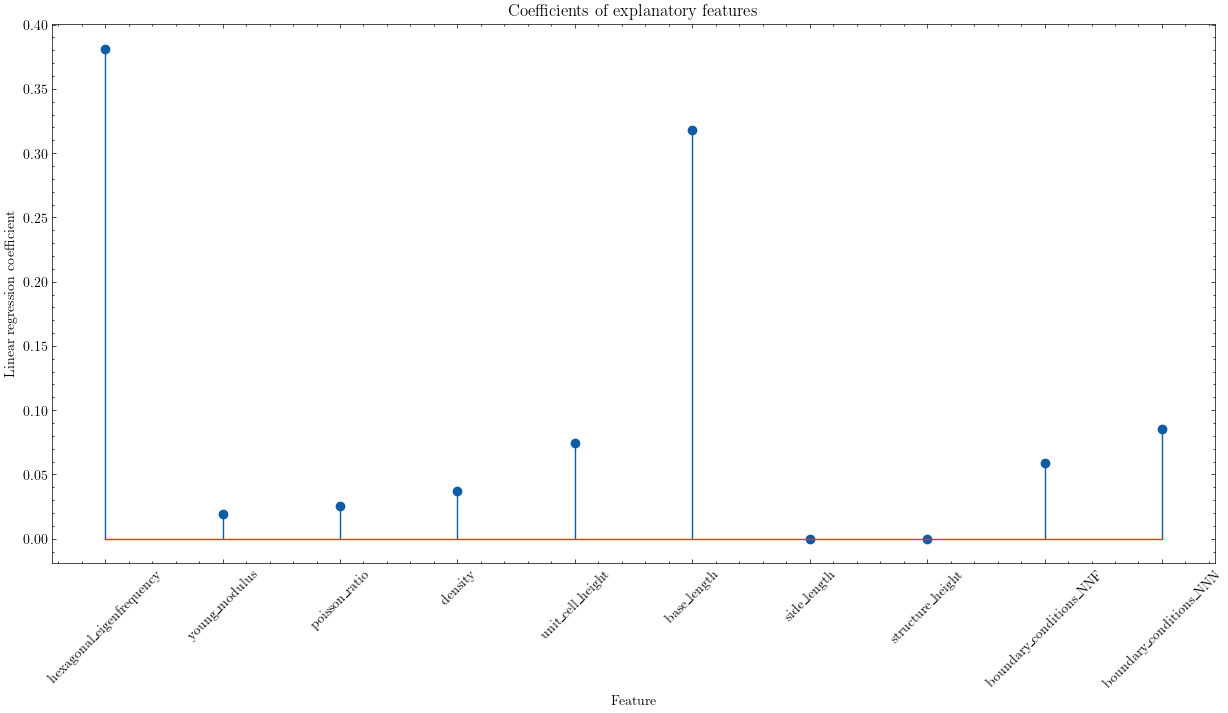

In [56]:
plt.figure(figsize=(15, 7))
plt.stem(X_test.columns, coefficients)
plt.title("Coefficients of explanatory features")
plt.xlabel("Feature")
plt.ylabel("Linear regression coefficient")
plt.xticks(rotation=45)

### Running a model excluding hexagonal natural frequency

In [57]:
X_train_reduced = X_train.drop("hexagonal_eigenfrequency", axis=1)
X_test_reduced = X_test.drop("hexagonal_eigenfrequency", axis=1)

In [58]:
reduced_model = model.fit(X_train_reduced, y_train)
reduced_model_predictions = reduced_model.predict(X_test_reduced)

In [59]:
print("R2:", r2_score(y_test, reduced_model_predictions))
print(
    f"Mean Absolute Error: {round(mean_absolute_error(y_test, reduced_model_predictions))} Hz"
)
print(
    f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y_test, reduced_model_predictions)))} Hz"
)

R2: 0.6299773084679088
Mean Absolute Error: 1744 Hz
Root Mean Squared Error: 2728 Hz


As expected, the performance of this model is much lower. Indeed, we have dropped the most important feature from the training data. However, the remaining features (even if their variance is limited given the size of the dataset) still explain 32% of the auxetic frequency's variability

In [60]:
# reduced_model_coefficients = reduced_model.coef_  # linear regression
reduced_model_coefficients = reduced_model.feature_importances_  # tree model

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'young_modulus'),
  Text(1, 0, 'poisson_ratio'),
  Text(2, 0, 'density'),
  Text(3, 0, 'unit_cell_height'),
  Text(4, 0, 'base_length'),
  Text(5, 0, 'side_length'),
  Text(6, 0, 'structure_height'),
  Text(7, 0, 'boundary_conditions_NNF'),
  Text(8, 0, 'boundary_conditions_NNN')])

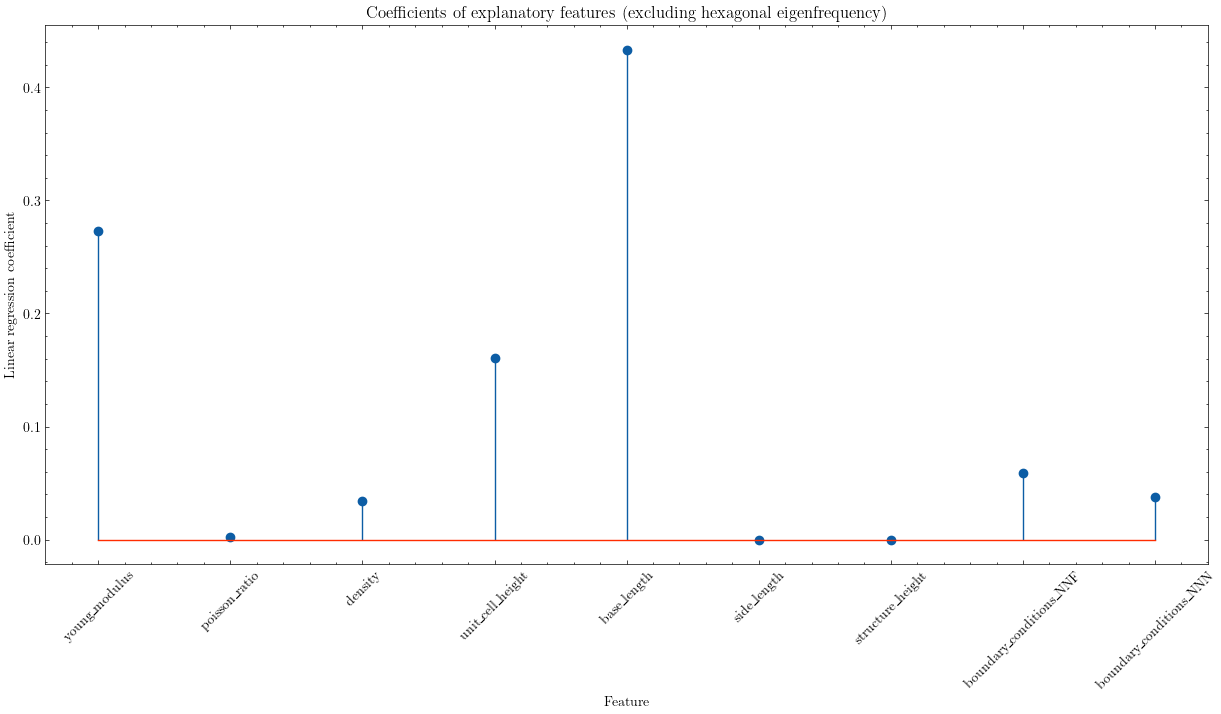

In [61]:
plt.figure(figsize=(15, 7))
plt.stem(X_test_reduced.columns, reduced_model_coefficients)
plt.title("Coefficients of explanatory features (excluding hexagonal eigenfrequency)")
plt.xlabel("Feature")
plt.ylabel("Linear regression coefficient")
plt.xticks(rotation=45)

Dropping `hexagonal_eigenfrequency` variable helps us better visualize the relative importances of the other variables.

## Limitations and next steps

#### Limitations
- Dataset size
- Features variance (linear regression assumptions)
- Data type (tabular data only) - one could have trained a model on images of materials and deformations

#### Next steps
- Further automate data collection and gather more data (quantity and type, e.g.: collect images of materials deformation)
- Run analysis of extended dataset
- Train and optimize different models (specific to each frequency order) and select most suitable model
- Extend work to other materials properties